In [7]:
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime
import pandas as pd
import numpy as np
import umap
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karamov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def log(message):
    now = datetime.datetime.now()
    print("{0} - {1}".format(now.strftime("%Y-%m-%d %H:%M:%S"), message))
    return

In [19]:
class DocumentsNormalizer:
    def __init__(self, normalization_algorithm=None, token_len_min=0, should_log=False):
        self._stop_words = []
        self.__read_stop_words()
        self._token_len_min = token_len_min
        self.should_log = should_log

    def normalize_documents(self, docs):
        log('start normalization')
        html_free_docs = docs.apply(self.__extract_row_text_from_html)
        log('end extract tow text from html')
        punctuation_free_docs = html_free_docs.apply(self.__remove_punctuation)
        log('end of removing  punctuation ')
        tokens_collections = punctuation_free_docs.apply(lambda x: word_tokenize(x.lower()))
        log('end tokenize')
        a = self.__remove_noise(tokens_collections)
        log('end of removing noise')
        return a.apply(lambda _tokens: " ".join(_tokens))

    def __remove_noise(self, token_collections):
        return token_collections.apply(
            lambda collection: list(filter(
                lambda token: token not in self._stop_words and not token.isdigit() and len(
                    token) >= self._token_len_min,
                collection)))

    @staticmethod
    def __to_dict(tokens):
        unique_tokens = {}
        for token in tokens:
            if token in unique_tokens:
                unique_tokens[token] += 1
            else:
                unique_tokens[token] = 1
        return unique_tokens

    @staticmethod
    def __extract_row_text_from_html(text):
        soup = BeautifulSoup(text, 'html.parser')
        html_free = soup.get_text(strip=True, separator=' ')
        return html_free

    @staticmethod
    def __remove_punctuation(text):
        chars = []
        for char in text:
            if char in string.punctuation:
                chars.append(' ')
            else:
                chars.append(char)
        return "".join(chars)

    def __read_stop_words(self):
        english_stop_words = stopwords.words("english")
        with open('./ru_stop_words.txt', mode='r', encoding='utf-8') as f:
            raw_stop_words = f.readlines()
            for stop_word in raw_stop_words:
                self._stop_words.append(stop_word.strip())
        self._stop_words = self._stop_words + english_stop_words

def create_frequency_table(min_df=0.1, max_df=0.98):
    data_set = pd.read_csv('./merged.csv').head(10000)
    normalizer = DocumentsNormalizer(should_log=True)
    corpus = normalizer.normalize_documents(data_set['description'])
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, dtype=np.uint16)
    frequency_table = vectorizer.fit_transform(corpus)
    return vectorizer.get_feature_names(), frequency_table

def save_frequency_table(terms, frequency_table):
    sparse.save_npz('./frequency_table', frequency_table)
    with open('./terms', 'w', encoding='utf-8') as f:
        f.write('\n'.join(terms))

def build_frequency_table():
    terms, frequency_table = create_frequency_table(min_df=0.005, max_df=0.99)
    save_frequency_table(terms, frequency_table)

In [5]:
def create_frequency_table(min_df=0.1, max_df=0.98):
    data_set = pd.read_csv('./merged.csv')
    normalizer = DocumentsNormalizer(should_log=True)
    corpus = normalizer.normalize_documents(data_set['description'])
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, dtype=np.uint16)
    frequency_table = vectorizer.fit_transform(corpus)
    return vectorizer.get_feature_names(), frequency_table

def save_frequency_table(terms, frequency_table):
    sparse.save_npz('./frequency_table', frequency_table)
    with open('./terms', 'w', encoding='utf-8') as f:
        f.write('\n'.join(terms))
        
def read_frequency_table():
    frequency_table = sparse.load_npz('./frequency_table.npz')
    terms = []
    with open('./terms', 'r', encoding='utf-8') as f:
        data = f.readlines()
        for i in data:
            terms.append(i.strip())
    return frequency_table, terms

def build_frequency_table():
    terms, frequency_table = create_frequency_table(min_df=0.005, max_df=0.99)
    save_frequency_table(terms, frequency_table)

In [21]:
#create frequency_table and save to npz file  called once
#build_frequency_table()
#log('end build frequency_table')

2020-04-13 16:20:12 - start normalization
2020-04-13 16:21:25 - end extract tow text from html
2020-04-13 16:21:42 - end of removing  punctuation 
2020-04-13 16:22:44 - end tokenize
2020-04-13 16:23:51 - end of removing noise
2020-04-13 16:24:04 - end build frequency_table


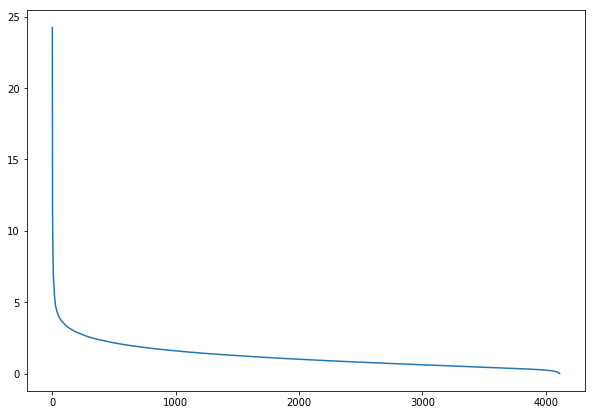

2020-04-20 13:39:44 - end calculate approximatios


In [17]:
#показывает значение сингулярых чисел на графике
def show_approximation(singular_value):
    plt.figure(figsize=(10, 7))
    plt.plot(range(0, len(singular_value)), singular_value)
    plt.show()
    log('end calculate approximatios')    
    
frequency_table, terms = read_frequency_table()
origignal_table = frequency_table.toarray()

svd_model = TruncatedSVD(n_components=len(terms)-1)
svd_model.fit(origignal_table)
show_approximation(svd_model.singular_values_)

In [41]:
#Кластеризация
def get_terms(topic_number, corpus, component):
    component_for_topic = component[topic_number, :][0]
    corpus_weight_for_topic = zip(corpus, component_for_topic)
    return np.array(sorted(corpus_weight_for_topic, key=lambda x: x[1], reverse=True)[:10])[:, 0]


def get_top_terms_for_even_documents(svd, component, corpus):
    significant_topic_for_each_row = np.argmax(svd, axis=1).reshape((svd.shape[0], 1))
    return np.apply_along_axis(get_terms, 1, significant_topic_for_each_row, corpus, component)    


cluser_count = 10
topic_count = 100

frequency_table, terms = read_frequency_table()
origignal_table = frequency_table.toarray()

svd_model = TruncatedSVD(n_components=topic_count)
topics = svd_model.fit_transform(origignal_table)
components = svd_model.components_
top_terms = get_top_terms_for_even_documents(topics, components, terms)
embedding = TSNE(n_components=2, metric='cosine', random_state=5).fit_transform(topics)

kmeans = KMeans(n_clusters=cluser_count, random_state=3)
clusters = kmeans.fit_predict(embedding)

print('end')

end


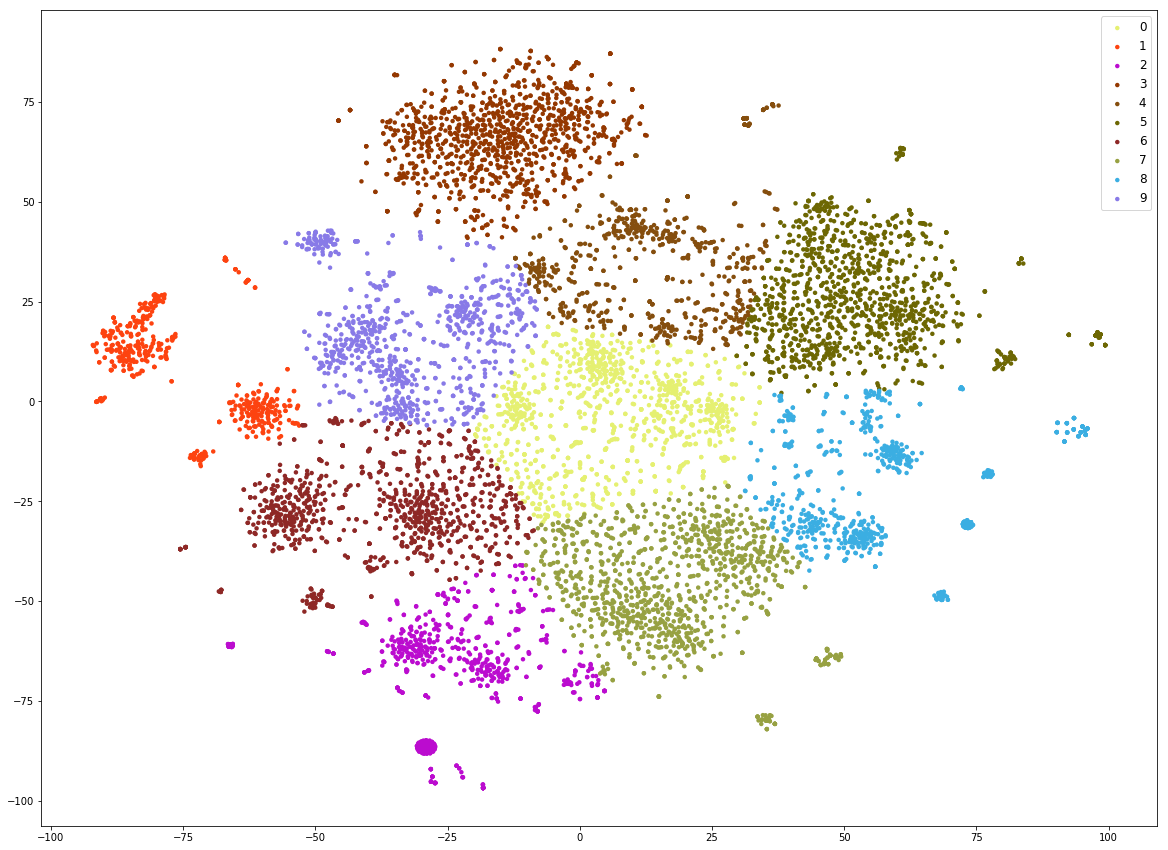

0   опыт работы 1с знание разработки компании разработка работа умение условия автором управления дополнительный доход тестирование заказы конструкторской драйвера свободный дистанционного java spring данных postgresql docker python php oracle работать работаем наших ищем задачи js команда интернет делать
-----------end cluster-----------
1   experience development work team skills knowledge software working 1с business обучения возможность данных контроль университета знаний университете проведение информации опыт работы знание разработки компании разработка работа умение условия python россии компания навыки веб владение дружный коллектив кода тестирования продаж тест linux языка тестирование php понимание битрикс net сайтов интернет
-----------end cluster-----------
2   опыт работы 1с знание разработки компании разработка работа умение условия android приложений ios java мобильных продаж kotlin sdk приложения разных оборудования технологических менять пробовать бюрократии битрикс пр

In [48]:
df = pd.DataFrame(clusters, columns=['cluster_n'])
df['Id'] = np.arange(len(df))
df['x'] = embedding[:, 0]
df['y'] = embedding[:, 1]

plt.figure(figsize=(20, 15))
group_by_cluster = df.groupby('cluster_n')
for name, group in group_by_cluster:
    c = np.array([np.random.rand(3,)]* len(group['Id']))
    plt.scatter(group['x'], group['y'],
                s=20,
                c=c,
                edgecolor='none',
                label=name)

plt.legend(fontsize=12)
plt.show()

df2 = pd.DataFrame(top_terms)
df2['cluster'] = clusters

group_by_cluster = df2.groupby('cluster')
top_words_by_cluster = []
for name, group in group_by_cluster:    
    top_terms_in_group = group.iloc[:, 0:10]
    unique_words_in_group = dict()
    for i, row in top_terms_in_group.iterrows():
        for j, word in row.items():
            if word in unique_words_in_group:
                continue
            else:
                unique_words_in_group[word] = 1
    top_words_by_cluster.append((name," ".join(unique_words_in_group.keys())))

for cluster_name, words in top_words_by_cluster:
    print(cluster_name,' ', words)
    print('-----------end cluster-----------')